# Implementing method to generate ruled rectangles around barrier islands
Test case on Hatteras Island, North Carolina (as of 12/2/2020)

The goal is to provide a Geoclaw function to identify and put ruled rectangles around barrier islands. We want to algorithmically generate rectangles to cover the entire island with minimum area spanned by the rectangles. I have below some basic components of the function, as applied to a test case, and a to-do list. 

In [2]:
%matplotlib inline
from pylab import *
from skimage import data, io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import math

import netCDF4

from clawpack.visclaw import colormaps, plottools
from clawpack.amrclaw import region_tools
from clawpack.geoclaw import topotools

from skimage.morphology import convex_hull_image, convex_hull_object, label
from skimage.measure import label, regionprops
from skimage.transform import rotate
from skimage import data, img_as_float
from skimage.util import invert
import skimage.io as skio
from skimage.color import rgb2gray

(-76.05000000000001, -75.050000000028, 34.75, 35.799999999970595)


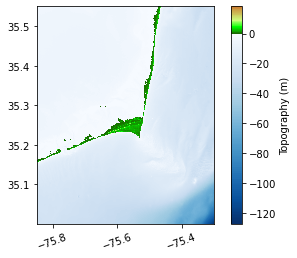

In [3]:
# plot topography
topo_path = 'clawpack_src/clawpack-v5.7.0/geoclaw/scratch/cape_hatteras_13_mhw_2006.nc'
topo_hat = topotools.read_netcdf(topo_path)
print(topo_hat.extent)

filter_region = (-75.85, -75.3, 35.0, 35.55)
topo = topo_hat.crop(filter_region)
topo.plot()

## Create convex hull around island region

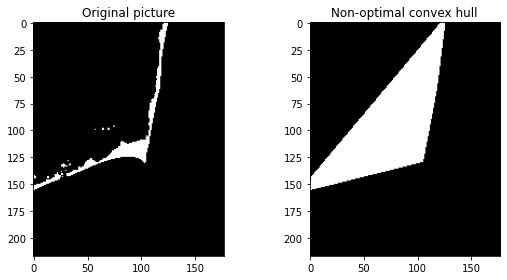

In [8]:
# transform image
im_src = skio.imread('hatteras_image.jpg')
image = rgb2gray(im_src)
image = invert(image)
chull = convex_hull_image(image)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax = axes.ravel()
ax[0].set_title('Original picture')
ax[0].imshow(image, cmap=plt.cm.gray)
ax[1].set_title('Non-optimal convex hull')
ax[1].imshow(chull, cmap=plt.cm.gray)

plt.tight_layout()
plt.show()

### Determine regions
We want to generate a better convex hull by measuring the concavity of the island. Then we can split the image into separate chunks and find the convex hull of each chunk. To do this, we use the median line of the island to compare the slope at different points, which will tell us where to cut the image.

#### Find median line

In [10]:
# helper function
def find_first_and_last(array, x):   
    '''
    Finds first and last occurrence of a value in an array
    Returns -1 if value not found
    '''
    first = -1
    last = -1
    
    for i in range(0, len(array)):
        if(array[i] != x):
            continue
        if(first == -1):
            first = i
        last = i
        
    return first, last        

def find_median_line(image):
    '''
    Finds array coordinates of median line through image
    '''
    
    # transpose image array
    imageT = np.transpose(image)
    #print(np.shape(imageT))

    # create array of indices of median points
    median_pts = []
    row_num = 0
    for row in imageT:
        first, last = find_first_and_last(row, True)
        #print(first, last)
        if(first != -1):
            if((first + last) %2 == 0):
                median_index = int((first + last) / 2)
            else:
                median_index = int((first + last + 1) / 2)
        
            #print(median_index)
            median_pts.append((row_num, median_index))

        row_num += 1
        
    return median_pts

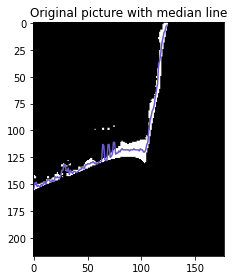

In [12]:
x, y = zip(*find_median_line(image))

fig, ax = plt.subplots(1, 1, figsize=(8, 4))

ax.set_title('Original picture with median line')
ax.imshow(image, cmap=plt.cm.gray)
ax.plot(x, y, 'slateblue')

cx, cy = zip(*find_median_line(chull))

plt.tight_layout()
plt.show()

#### Find points to cut the image

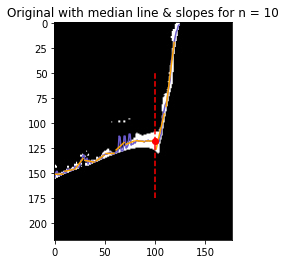

In [14]:
# find slope of best fit line on median through n points at a time

x, y = zip(*find_median_line(image))
cx, cy = zip(*find_median_line(chull))

# set up plot
fig, ax = plt.subplots(figsize=(8, 4))
ax.set_title('Original with median line & slopes for n = 10')
ax.imshow(image, cmap=plt.cm.gray)
ax.plot(x, y, 'slateblue')

n = 10 
med_line = find_median_line(image)

i = 0
m_prev = 0 # INITIALIZE THIS AS SOMETHING DIFFERENT (slope between first 2 points?)
cut_pts = []

while i < (len(med_line) - n):
    
    selected_pts = med_line[i:i+n-1]
    x, y = zip(*selected_pts)
    
    # find best fit line
    y_fit = np.poly1d(np.polyfit(x, y, 1))(x)
    # calculate slope
    m = (y_fit[-1] - y_fit[0]) / (x[-1] - x[0])
    
    ax.plot(x, y_fit, 'orange')

    m_diff = np.abs(m_prev - m)
    if(m_diff >= 4): # MAYBE USE RATIO INSTEAD OF CONSTANT
        cut_pts.append(i)
        ax.plot(i, med_line[i][1], 'ro')
        ax.plot([i, i], [175, 50], 'r--')
                
    m_prev = m        
    
    i += n

In [16]:
def cut_points(median_line, n):
    '''
    Finds points to cut the image based on slope of median line through n points at a time.
    '''
    
    i = 0
    m_prev = 0 # INITIALIZE THIS AS SOMETHING DIFFERENT (slope between first 2 points?)
    # OR JUST DO NOTHING IN FUNCTION IF i=0
    cut_points = []

    while i < (len(median_line) - n):        
        
        # select the next n points
        selected_pts = median_line[i:i+n-1]
        x, y = zip(*selected_pts)

        # best fit line through the selected points evaluated at x
        y_fit = np.poly1d(np.polyfit(x, y, 1))(x)
        
        # calculate slope
        m = (y_fit[-1] - y_fit[0]) / (x[-1] - x[0])

        m_diff = np.abs(m_prev - m)
        
        # add a cut point if difference between slopes is ... 
        if(m_diff >= 4): # MAYBE USE RATIO OR PERCENT CHANGE INSTEAD
            cut_points.append((i, median_line[i][1]))

        m_prev = m 
        
        i += n
        
    return cut_points

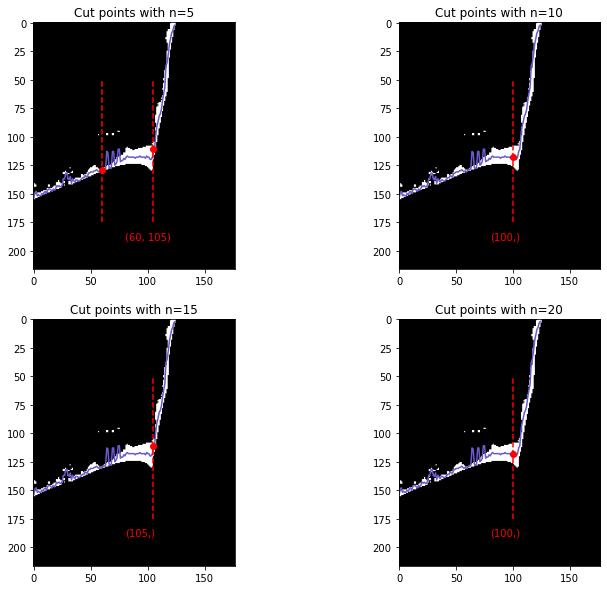

In [17]:
med_line = find_median_line(image)

x, y = zip(*find_median_line(image))

# plot results for different values of n
fig, ax = plt.subplots(2, 2, figsize=(12,10))
ax = ax.ravel()

i = 0
for n in range(5, 25, 5):
    cut_x, cut_y = zip(*cut_points(med_line, n))    
    
    ax[i].set_title('Cut points with n={}'.format(n))
    ax[i].imshow(image, cmap=plt.cm.gray)
    ax[i].plot(x, y, 'slateblue')
    ax[i].plot(cut_x, cut_y, 'ro')
    ax[i].plot([cut_x, cut_x], [175, 50], 'r--')
    ax[i].annotate('{}'.format(cut_x), xy=(75, 180), xytext=(80, 190), color = 'red')
    
    i += 1

# NOTE: function produces multiple cut points for n < 7
# and doesn't produce cut points for n > 20

#### Apply convex hull to regions

In [19]:
# draw separate convex hulls using cut points with n=10
image2 = np.copy(image) # make copy of original image array

n = 10
cut_point = cut_points(find_median_line(image2), n)
# extract x coordinate (corresponds to column of array)
cut_col = cut_point[0][0]

image2[:,cut_col:] = np.where(image2[:,cut_col:] > 0, 2, image2[:,cut_col:])
chull2 = convex_hull_object(image2, connectivity=2) #SEE WHAT 1 DOES

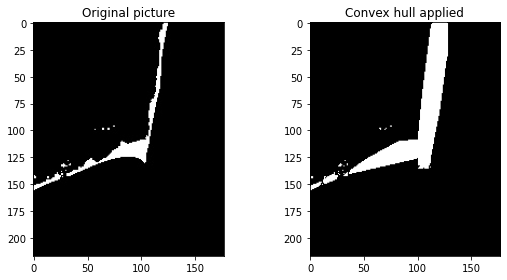

In [20]:
# plot results
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax = axes.ravel()

ax[0].set_title('Original picture')
ax[0].imshow(image, cmap=plt.cm.gray)

ax[1].set_title('Convex hull applied')
ax[1].imshow(chull2, cmap=plt.cm.gray)

plt.tight_layout()
plt.show()

## Cover convex hull with N rectangles
Now we use minimum bounding boxes to generate rectangles covering the white space with the least amount of black space.

### Bounding box of entire region

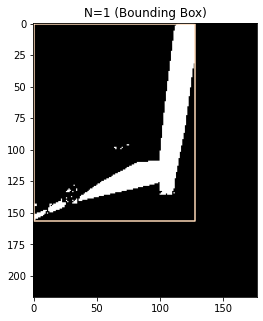

In [22]:
regions = regionprops(chull2.astype(int))

fig, ax = plt.subplots(figsize=(4, 6))
ax.imshow(chull2, cmap=plt.cm.gray)
ax.set_title('N=1 (Bounding Box)')

for region in regions:
    # min/max row/column for bounding box
    minr, minc, maxr, maxc = region.bbox
    
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    ax.plot(bx, by, 'peachpuff', linewidth=1.5)

plt.show()

### Vertical rectangles for N=20

Total area for 20 rectangles: 4582
Total water area: 1226
Total land area: 3356
Percent land area: 0.7324


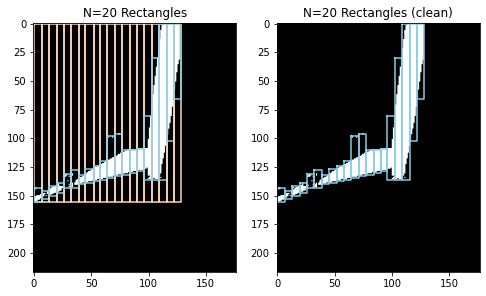

In [23]:
# number of rectangles
N = 20

#diff_r = maxr - minr
diff_c = maxc - minc

c_step = diff_c / N 

fig, ax = plt.subplots(1, 2, figsize=(8, 6))
ax[0].imshow(chull2, cmap=plt.cm.gray)
ax[0].set_title('N={} Rectangles'.format(N))
ax[1].imshow(chull2, cmap=plt.cm.gray)
ax[1].set_title('N={} Rectangles (clean)'.format(N))

total_area = 0
total_water = 0

for i in range(0, N): 
    leftc = math.ceil(minc + i*c_step)
    rightc = min(math.ceil(minc + (i+1)*c_step), maxc)
    bx = (leftc, rightc, rightc, leftc, leftc)
    by = (minr, minr, maxr, maxr, minr)
    ax[0].plot(bx, by, 'peachpuff', linewidth=1.5)

    # find bounding box for each rectangle region
    rect_region = regionprops(chull2[:, leftc:rightc].astype(int))

    for region in rect_region:
        # min/max row/column for bounding box
        rect_minr, rect_minc, rect_maxr, rect_maxc = region.bbox
        # number of pixels in bounding box
        area = region.bbox_area
    
        rect_bx = (rect_minc, rect_maxc, rect_maxc, rect_minc, rect_minc)
        rect_bx_plus_left = tuple(x+leftc for x in rect_bx)
        rect_by = (rect_minr, rect_minr, rect_maxr, rect_maxr, rect_minr)
        
    ax[0].plot(rect_bx_plus_left, rect_by, 'skyblue', linewidth=1.5)
    ax[1].plot(rect_bx_plus_left, rect_by, 'skyblue', linewidth=1.5)
    
    total_area += area
    
    # count number of non-island pixels (where array is False)
    chull2_cropped = chull2[rect_minr:rect_maxr, leftc + rect_minc:leftc + rect_maxc]
    water = np.count_nonzero(chull2_cropped == False)
    
    total_water += water
    
    
print("Total area for {} rectangles: {}".format(N, total_area))
print("Total water area: {}".format(total_water))
print("Total land area: {}".format(total_area - total_water))
print("Percent land area: {}".format(round((total_area - total_water) / total_area, 4)))

### Horizontal rectangles for N=20

Total area for 20 rectangles: 4989
Total water area: 1633
Total land area: 3356
Percent land area: 0.6727


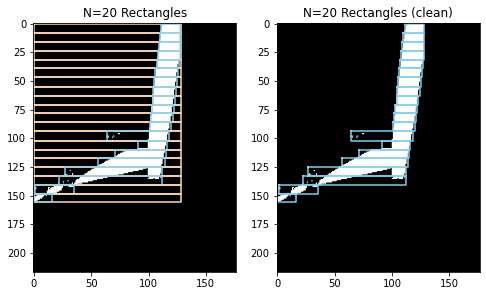

In [24]:
diff_r = maxr - minr
#diff_c = maxc - minc

r_step = diff_r / N 

fig, ax = plt.subplots(1, 2, figsize=(8, 6))
ax[0].imshow(chull2, cmap=plt.cm.gray)
ax[0].set_title('N={} Rectangles'.format(N))
ax[1].imshow(chull2, cmap=plt.cm.gray)
ax[1].set_title('N={} Rectangles (clean)'.format(N))

total_area = 0
total_water = 0

for i in range(0, N): 
    lowerr = math.ceil(minr + i*r_step)
    upperr = min(math.ceil(minr + (i+1)*r_step), maxr)
    bx = (minc, maxc, maxc, minc, minc)
    by = (lowerr, lowerr, upperr, upperr, lowerr)
    ax[0].plot(bx, by, 'peachpuff', linewidth=1.5)

    # find bounding box for each rectangle region
    rect_region = regionprops(chull2[lowerr:upperr, :].astype(int))

    for region in rect_region:
        # min/max row/column for bounding box
        rect_minr, rect_minc, rect_maxr, rect_maxc = region.bbox
        # number of pixels in bounding box
        area = region.bbox_area
    
        rect_bx = (rect_minc, rect_maxc, rect_maxc, rect_minc, rect_minc)
        
        rect_by = (rect_minr, rect_minr, rect_maxr, rect_maxr, rect_minr)
        rect_by_plus_lower = tuple(x+lowerr for x in rect_by)
        
    ax[0].plot(rect_bx, rect_by_plus_lower, 'skyblue', linewidth=1.5)
    ax[1].plot(rect_bx, rect_by_plus_lower, 'skyblue', linewidth=1.5)
    
    total_area += area
    
    # count number of non-island pixels (where array is False)
    chull2_cropped = chull2[lowerr + rect_minr:lowerr + rect_maxr, rect_minc:rect_maxc]
    water = np.count_nonzero(chull2_cropped == False)
    
    total_water += water

print("Total area for {} rectangles: {}".format(N, total_area))
print("Total water area: {}".format(total_water))
print("Total land area: {}".format(total_area - total_water))
print("Percent land area: {}".format(round((total_area - total_water) / total_area, 4)))


### Putting this in a function . . . 

In [25]:
def draw_rectangles(image, N, orientation='vertical', plot=True):
    '''  
    Params:
        image: ndarray
            Image of island region (one labelled component)
        N: int
            Number of rectangles to draw
        orientation: string
            Horizontal or vertical rectangles
        plot: boolean
            Whether or not to show final image
        ADD STUFF HERE
        
    Returns:
        total_area: int
            Total area of rectangles
        total_water: int
            Total area of water (non-island) pixels covered by rectangles
        
    '''
    
    if(orientation=='vertical'):
        o = 0 
    else:
        o = 1
    
    # find bounding box for entire convex hull
    regions = regionprops(image.astype(int))

    for region in regions:
        # min/max row/column for bounding box
        minr, minc, maxr, maxc = region.bbox
    
    mins = [minc, minr]
    maxs = [maxc, maxr]
    mino = mins[o]
    maxo = maxs[o]
    
    diff = [maxc - minc, maxr - minr]    
    step = diff[o] / N 
    
    # set up plot
    if(plot==True):
        fig, ax = plt.subplots(1, 1, figsize=(4, 6))
        ax.imshow(chull2, cmap=plt.cm.gray)
        ax.set_title('N={} Rectangles'.format(N))
    
    # initialize total area and water
    total_area = 0
    total_water = 0
    
    # generate rectangles 
    for i in range(0, N): 
        lower = math.ceil(mino + i*step)
        upper = min(math.ceil(mino + (i+1)*step), maxo)    

        # find bounding box for each rectangle region
        if(o == 0):
            rect_region = regionprops(image[:, lower:upper].astype(int))
        else:
            rect_region = regionprops(image[lower:upper, :].astype(int))

        for region in rect_region:
            # min/max row/column for bounding box
            rect_minr, rect_minc, rect_maxr, rect_maxc = region.bbox
            # number of pixels in bounding box
            area = region.bbox_area

            rect_bx = (rect_minc, rect_maxc, rect_maxc, rect_minc, rect_minc)
            rect_bx_plus_lower = tuple(x + lower for x in rect_bx)
            rect_by = (rect_minr, rect_minr, rect_maxr, rect_maxr, rect_minr)
            rect_by_plus_lower = tuple(x + lower for x in rect_by)
        
        # plot rectangles
        if(plot==True):
            if(o == 0):
                ax.plot(rect_bx_plus_lower, rect_by, 'skyblue', linewidth=1.5)
            else:
                ax.plot(rect_bx, rect_by_plus_lower, 'skyblue', linewidth=1.5)

        total_area += area

        # count number of non-island pixels (where array is False)
        if(o == 0):
            image_cropped = chull2[rect_minr:rect_maxr, lower + rect_minc:lower+ rect_maxc]
        else:
            image_cropped = chull2[lower + rect_minr:lower + rect_maxr, rect_minc:rect_maxc]
        
        water = np.count_nonzero(image_cropped == False)
        total_water += water
        
    
    return total_area, total_water


(4256, 900)

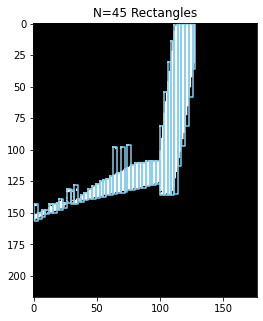

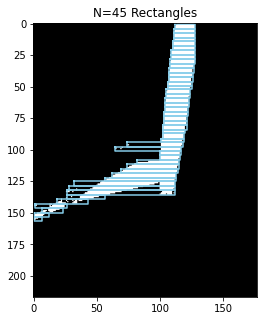

In [34]:
# test above function
draw_rectangles(chull2, N=45, orientation='vertical', plot=True)
draw_rectangles(chull2, N=45, orientation='horizontal', plot=True)

Text(0.5, 1.0, 'Percent land area as number of rectangles increases')

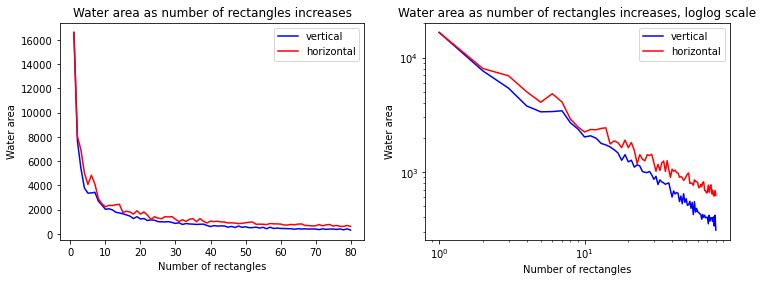

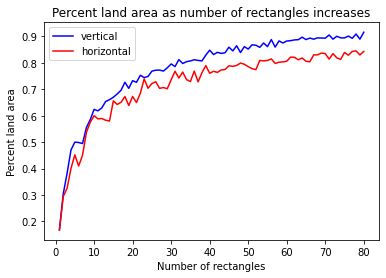

In [20]:
# plot water area as N increases for vertical and horizontal rectangles
N_arr = range(1, 81)
vwater_arr = []
hwater_arr = []

vland_arr = []
hland_arr = []

for N in N_arr:
    vtotal_area, vtotal_water = draw_rectangles(chull2, N, orientation='vertical', plot=False)
    vwater_arr.append(vtotal_water)
    vland_arr.append((vtotal_area - vtotal_water) / vtotal_area)
    
    htotal_area, htotal_water = draw_rectangles(chull2, N, orientation='horizontal', plot=False)
    hwater_arr.append(htotal_water)
    hland_arr.append((htotal_area - htotal_water) / htotal_area)

fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].plot(N_arr, vwater_arr, 'b', label='vertical')
ax[0].plot(N_arr, hwater_arr, 'r', label='horizontal')
ax[0].set_xlabel('Number of rectangles')
ax[0].set_ylabel('Water area')
ax[0].legend(loc='best')
ax[0].set_title('Water area as number of rectangles increases')

ax[1].loglog(N_arr, vwater_arr, 'b', label='vertical')
ax[1].loglog(N_arr, hwater_arr, 'r', label='horizontal')
ax[1].set_xlabel('Number of rectangles')
ax[1].set_ylabel('Water area')
ax[1].legend(loc='best')
ax[1].set_title('Water area as number of rectangles increases, loglog scale')

# plot percent land area
fig, ax = plt.subplots(1, 1)
ax.plot(N_arr, vland_arr, 'b', label='vertical')
ax.plot(N_arr, hland_arr, 'r', label='horizontal')
ax.set_xlabel('Number of rectangles')
ax.set_ylabel('Percent land area')
ax.legend(loc='best')
ax.set_title('Percent land area as number of rectangles increases')


## Test on image rotated 90º clockwise (not working yet)

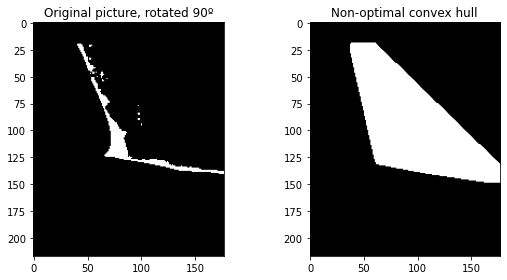

In [35]:
image90 = rotate(image, 270) # degrees counterclockwise
image90_2 = np.copy(image90) # make copy of original image array

n = 10
cut_point = cut_points(find_median_line(image90_2), n)
# extract x coordinate (corresponds to column of array)
cut_col = cut_point[0][0]

image90_2[:,cut_col:] = np.where(image90_2[:,cut_col:] > 0, 2, image90_2[:,cut_col:])

chull90_2 = convex_hull_object(image90_2, connectivity=2) #SEE WHAT 1 DOES

# plot results
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax = axes.ravel()

ax[0].set_title('Original picture, rotated 90º')
ax[0].imshow(image90, cmap=plt.cm.gray)

ax[1].set_title('Non-optimal convex hull')
ax[1].imshow(chull90_2, cmap=plt.cm.gray)

plt.tight_layout()
plt.show()

In [29]:
med_line90 = find_median_line(image90)

x, y = zip(*find_median_line(image90))

fig, ax = plt.subplots(2, 2, figsize=(12,10))
ax = ax.ravel()

i = 0
for n in range(5, 25, 5):
    cut_x, cut_y = zip(*cut_points(med_line90, n))    
    
    ax[i].set_title('Cut points with n={}'.format(n))
    ax[i].imshow(image90, cmap=plt.cm.gray)
    ax[i].plot(x, y, 'slateblue')
    ax[i].plot(cut_x, cut_y, 'ro')
    ax[i].plot([cut_x, cut_x], [175, 50], 'r--')
    ax[i].annotate('{}'.format(cut_x), xy=(75, 180), xytext=(80, 190), color = 'red')
    
    i += 1

# To-do:

1. Fix functions to work for any orientation
2. Test on arbitrarily rotated images
3. Test on other islands
4. Implement parameter options (efficiency, buffer width, etc.)
5. Use vertical and horizontal rectangles on the same image based on length and width of region (maybe)
6. Find a way to identify an island given a topography region 
    * e.g. we don't want to include other non-island land areas in a given image
    * not sure if this is possible without user specification though